# WARNING : this notebook still needs modernising. See [iris_example_code#12](https://github.com/scitools-classroom/iris_example_code/issues/12) for more details

## Creating an Aux Coordinate Factory ##


### Introduction ###

Aux coordinate factories are useful for generating an auxiliary coordinate in a deferred manner when it is not appropriate to generate an aux coord in the default manner, for example because the resultant cube would become unnecessarily large.

However, much like a real factory, they are not easy to build! To build an aux factory we are going to have to define our own class, which inherits from the general aux factory class, specifically for the aux coordinates we need to derive here.

Please note that there are plans in place to improve the aux factory API so that in the future it will be much easier to build such a bespoke aux factory. When that occurs this example **will no longer work**. But it will be much easier to build an aux factory!

As ever, we will start with importing some required libraries.

In [2]:
import numpy as np

import iris
import iris.aux_factory as aux_factory

print (iris.__version__)

3.10.0


### Define data and constants ###

Let's import the cube that we are going to build an aux factory for. One further slightly unusual piece of data we will need for our aux factory is the coordinate dimension, as determined by the cube method `coord_dims`, for each coordinate on the cube that we will pass to our aux factory. To demonstrate what it does, the result for each dimension is also printed.

We will also need a few physical constants defined, so they're going in here too.

In [3]:
EARTH_RAD_CORR_FAC = 1.33;
EARTH_RADIUS = 6371229;
KEA = EARTH_RADIUS * EARTH_RAD_CORR_FAC
EARTH_CIRC =  2.0 * np.pi * EARTH_RADIUS

cube = iris.load_cube('example_data/CICube.nc')
print (cube)

azis = cube.coord('azimuth')
rngs = cube.coord('range')
azis_coord_dims = cube.coord_dims(azis)
rngs_coord_dims = cube.coord_dims(rngs)
print (azis_coord_dims)
print (rngs_coord_dims)

Clutter indicator / (unknown)       (azimuth: 360; range: 425)
    Dimension coordinates:
        azimuth                             x           -
        range                               -           x
    Scalar coordinates:
        altitude                    511.0 meter
        beam_width                  1.0 degree
        featureType                 ppi
        frequency                   5.608008981 GHz
        latitude                    52.39805555555556 degrees
        longitude                   -2.593611111111111 degrees
        platform_altitude           511.0 meter
        platform_id                 3
        scan_elevation_angle        0.0 degree
        station_wmo_id              Clee Hill
        time                        2013-07-20 11:59:00
    Attributes:
        Conventions                 'CF-1.5'
(0,)
(1,)


### Factory! ###

It's time to take a deep breath and start building our aux coordinate factory. This factory will inherit from the general `iris.aux_factory` class but we will need to define a number of functions of our own, including the very important function that calculates the values of the aux coordinates that our factory will build from our cube's existing dimension coordinates.

In [13]:
class LatLonFromRangeAziFactory(aux_factory.AuxCoordFactory):
    '''
    Defines a factory that calculates lat/lon coordinates based on azimuth and range values.
    
    Uses the equation:
    ???
    
    '''
    
    def __init__(self, cube):
        '''
        Define a factory that calculates lat/lon coordinates based on azimuth and range values.
        
        Uses the equation:
        ???
        
        Arg:
        
        * cube:
            The cube from which the aux factory is to be constructed.
        
        '''
        super(LatLonFromRangeAziFactory, self).__init__()
        
        self.cube = cube
        self.units = 'degrees'
        self.attributes = {}
        
        self.rng = self.cube.coord('range')
        self.azi = self.cube.coord('azimuth')
        self.site_lat = self.cube.coord('latitude').points
        self.site_lon = self.cube.coord('longitude').points
        self.site_alt = self.cube.coord('altitude').points
        self.beam_elev = cube.coord('scan_elevation_angle').points
        
    @property
    def dependencies(self):
        '''
        Returns a dictionary mapping from constructor argument names to
        the corresponding coordinates.

        '''
        return {'range': self.rng, 'azimuth': self.azi}
    
    def _equation(self, rng, azi, coord):
        '''
        Performs the calculation alt/range/site location --> obs lats/lons.
        
        '''
        h = (np.sqrt(rng**2 + KEA**2 + rng*2*KEA*np.sin(self.beam_elev*(np.pi/180))) -
             KEA + self.site_alt[0])
        s = KEA * np.arcsin((rng*np.cos(self.beam_elev[0] * (np.pi/180))) / (KEA+h))
 
        result = None
        if coord == 'lat':
            result = self.site_lat + s*np.cos(azi * np.pi/180.0) * 360.0 / EARTH_CIRC
        elif coord == 'lon':                 
            result = (self.site_lon + s*np.sin(azi * np.pi/180.0) * 360.0 /
                      (EARTH_CIRC * np.cos(self.site_lat * np.pi/180.0)))
        else:
            raise ValueError('Expected coord to be one of (lat, lon), got {}'.format(coord)) 
        return result
    
    def make_coord(self, coord_dims_func, coord='lat'):
        '''
        Returns a new :class:`iris.coords.AuxCoord` as defined by this
        factory.

        Arg:

        * coord_dims_func:
            A callable which can return the list of dimensions relevant
            to a given coordinate.
            See `iris.cube.Cube.coord_dims()`.

        Kwarg:
        
        * coord (lat, lon):
            String defining the aux coord to calculate. Defaults to 'lat'.
            
        '''
        # Set standard_name based on input coord.
        std_name = None
        if coord == 'lat':
            std_name = 'grid_latitude'
        elif coord == 'lon':
            std_name = 'grid_longitude'
        else:
            raise ValueError('Expected coord to be one of (lat, lon), got {}'.format(coord)) 

        # Which dimensions are relevant?
        derived_dims = self.derived_dims(coord_dims_func)
        dependency_dims = self._dependency_dims(coord_dims_func)

        # Build a "lazy" points array.
        nd_points_by_key = self._remap(dependency_dims, derived_dims)

        # Define the function here to obtain a closure.
        def calc_points():
            return self._equation(nd_points_by_key['range'],
                                  nd_points_by_key['azimuth'],
                                  coord)
        shape = self._shape(nd_points_by_key)
        points = aux_factory.LazyArray(shape, calc_points)
        
        bounds = None
        if ((self.rng and self.rng.nbounds) or (self.azi and self.azi.nbounds)):
            # Build a "lazy" bounds array.
            nd_values_by_key = self._remap_with_bounds(dependency_dims,
                                                       derived_dims)

            # Define the function here to obtain a closure.
            def calc_bounds():
                rng = nd_values_by_key['range']
                azi = nd_values_by_key['azimuth']
                ok_bound_shapes = [(), (1,), (2,)]
                if rng.shape[-1:] not in ok_bound_shapes:
                    raise ValueError('Invalid range coordinate bounds.')
                if azi.shape[-1:] not in ok_bound_shapes:
                    raise ValueError('Invalid azimuth coordinate bounds.')
                return self._equation(rng, azi, coord)
            
            b_shape = self._shape(nd_values_by_key)
            bounds = aux_factory.LazyArray(b_shape, calc_bounds)

        aux_coord = iris.coords.AuxCoord(points,
                                         standard_name=std_name,
                                         long_name=self.long_name,
                                         var_name=self.var_name,
                                         units=self.units,
                                         bounds=bounds,
                                         attributes=self.attributes,
                                         coord_system=self.coord_system)
        return aux_coord
        
    def make_coords(self, coord_dims_func):
        '''
        As this aux factory needs to make *two* coords (lat, lon), we call :func:make_coord()
        twice, once for each coord.
        
        Arg:

        * coord_dims_func:
            A callable which can return the list of dimensions relevant
            to a given coordinate.
            See `iris.cube.Cube.coord_dims()`.
        
        '''
        lat_aux_coord = self.make_coord(coord_dims_func, coord='lat')
        lon_aux_coord = self.make_coord(coord_dims_func, coord='lon')
        return lat_aux_coord, lon_aux_coord

    def update(self, old_coord, new_coord=None):
        '''
        Notifies the factory of the removal/replacement of a coordinate
        that might be a dependency.

        Args:

        * old_coord:
            The coordinate to be removed/replaced.
        * new_coord:
            If None, any dependency using old_coord is removed, othewise
            any dependency using old_coord is updated to use new_coord.

        '''
        if self.rng is old_coord:
            if new_coord and new_coord.nbounds not in (0, 2):
                raise ValueError('Invalid range coordinate:'
                                 ' must have either 0 or 2 bounds.')
            self.rng = new_coord
        elif self.azi is old_coord:
            if new_coord and new_coord.nbounds not in (0, 2):
                raise ValueError('Invalid azimuth coordinate:'
                                 ' must have either 0 or 2 bounds.')
            self.azimuth = new_coord

In [14]:
print 

<function print(*args, sep=' ', end='\n', file=None, flush=False)>

### Producing aux coords with the factory ###

With our shiny new aux coord factory defined we can now get on and use it to make lat and lon aux coords. We need to define a function to use as `coord_dims_func` as required by the method `make_coord` on our aux factory. Happily, the cube method `coord_dims` that we met earlier will do that job for us nicely.

In [15]:
factory = LatLonFromRangeAziFactory(cube)
lat_aux, lon_aux = factory.make_coords(cube.coord_dims)
print('{}\n\n{}'.format(lat_aux, lon_aux))

AttributeError: 'LatLonFromRangeAziFactory' object has no attribute '_shape'

Seeing as we have got so far, we might as well push the boat fully out and plot the cube's data against our new aux coords:

NameError: name 'lon_aux' is not defined

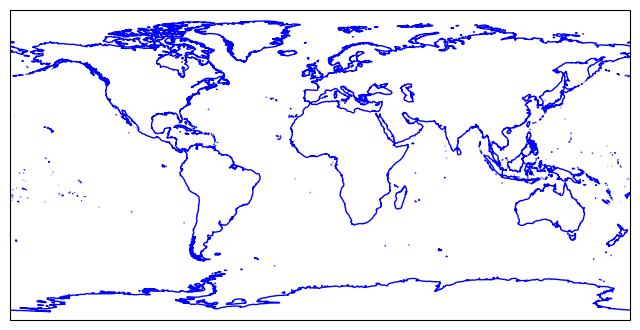

In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines('50m', color='b')
plt.pcolormesh(lon_aux.points, lat_aux.points, cube.data)
plt.show()